# Acquisition functions

Now that we've got the basics of DeepSensor's active learning functionality
from the [](./active_learning.ipynb) page, here we will focus on the various
acquisition functions available in the package.
Again, we will use the pre-trained ERA5 spatial interpolation ConvNP from the previous [](training.ipynb) page.

For an up-to-date list of acquisition functions see the API documentation for the [`deepsensor.active_learning.acquisition_fns` module](../reference/active_learning/acquisition_fns.rst)


## Set-up

In [37]:
import logging

logging.captureWarnings(True)

import deepsensor.torch
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, \
    get_gldas_land_mask
from deepsensor.model import ConvNP
from deepsensor.train import set_gpu_default_device

import cartopy.crs as ccrs
import pandas as pd

In [38]:
# Training/data config
data_range = ("2010-01-01", "2019-12-31")
train_range = ("2010-01-01", "2018-12-31")
val_range = ("2019-01-01", "2019-12-31")
date_subsample_factor = 10
extent = "usa"
station_var_IDs = ["TAVG"]
era5_var_IDs = ["2m_temperature"]
lowres_auxiliary_var_IDs = ["elevation"]
cache_dir = "../../.datacache"
deepsensor_folder = "../deepsensor_config/"
model_folder = "../model/"
verbose_download = True

val_dates = pd.date_range(val_range[0], val_range[1])[::date_subsample_factor]

In [3]:
era5_raw_ds = get_era5_reanalysis_data(era5_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir, verbose=verbose_download, num_processes=8)
lowres_aux_raw_ds = get_earthenv_auxiliary_data(lowres_auxiliary_var_IDs, extent, "100KM", cache=True, cache_dir=cache_dir, verbose=verbose_download)
land_mask_raw_ds = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir, verbose=verbose_download)

data_processor = DataProcessor(x1_name="lat", x2_name="lon")
era5_ds = data_processor(era5_raw_ds)
lowres_aux_ds, land_mask_ds = data_processor([lowres_aux_raw_ds, land_mask_raw_ds], method="min_max")

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
lowres_aux_ds["cos_D"] = doy_ds["cos_D"]
lowres_aux_ds["sin_D"] = doy_ds["sin_D"]

100%|██████████████████████████████████████████████████████████████████| 120/120 [00:02<00:00, 45.88it/s]


1.41 GB loaded in 3.68 s


In [4]:
crs = ccrs.PlateCarree()
test_date = pd.Timestamp("2019-06-25")

In [5]:
# Run on GPU if available by setting GPU as default device
set_gpu_default_device()

In [6]:
task_loader = TaskLoader(
    context=[era5_ds, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader.load_dask()
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)


In [7]:
# Load model
model = ConvNP(data_processor, task_loader, deepsensor_folder)

In [8]:
X_c = 100

In [9]:
task = task_loader(test_date, (X_c, "all", "all"), seed_override=42)

In [10]:
# xarray object containing a mask to remove ocean points from the search and target points
mask_ds = land_mask_raw_ds

## Sequential greedy algorithm

Sequentially loop over all search points, passing a query observation to the model at that point and computing the change in acquisition function.

These acquisition functions can be computationally expensive because they require one model forwards pass per query point,
so we will coarsen the search space for the purposes of demonstration.

In [11]:
from deepsensor.active_learning import GreedyAlgorithm

greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds.coarsen(lat=15, lon=15, boundary="trim").mean(),  # Coarsen search points to speed up computation
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    N_new_context=3,
    progress_bar=True,
)

### MeanStddev
Minimise the model's mean standard deviation - i.e. minimise the expected MAE under the model.

100%|██████████████████████████████████████████████████████████████████| 579/579 [00:32<00:00, 17.91it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Averaging acquisition function over dims for plotting: ['time']


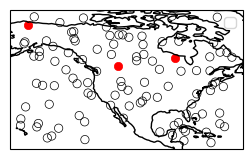

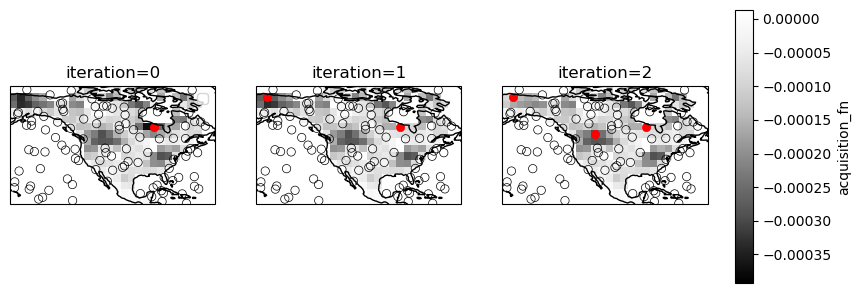

In [12]:
from deepsensor.active_learning.acquisition_fns import MeanStddev

acquisition_fn = MeanStddev(model)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task, diff=True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

### pNormStddev
Computing the p-norm of the standard deviations can be used to place greater emphasis on reducing the largest standard deviations

100%|██████████████████████████████████████████████████████████████████| 579/579 [00:32<00:00, 17.77it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Averaging acquisition function over dims for plotting: ['time']


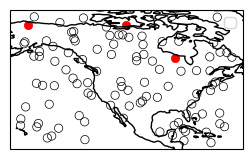

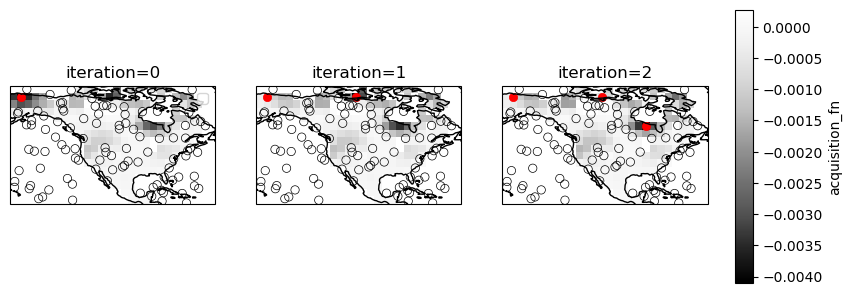

In [13]:
from deepsensor.active_learning.acquisition_fns import pNormStddev

acquisition_fn = pNormStddev(model, p=6)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, task, diff=True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

## Oracle sequential greedy algorithm

Acquisition functions that inherit from `AcquisitionFunctionOracle` use the true target values to compute performance metrics.
This assumes that the true target values are available at all target points, which will often not be the case.

Using oracle acquisition functions requires that the `GreedyAlgorithm` is initialised with a `task_loader` object so that it can load the true target values for each target point.

In [14]:
greedy_alg_with_groundtruth = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds.coarsen(lat=10, lon=10, boundary="trim").mean(),  # Coarsen search points to speed up computation
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    query_infill=era5_ds,
    proposed_infill=era5_ds,
    N_new_context=3,
    task_loader=task_loader,
    verbose=True,
    progress_bar=True,
)

query_infill not on search grid, interpolating.
proposed_infill not on search grid, interpolating.


### OracleMAE

100%|████████████████████████████████████████████████████████████████| 1311/1311 [01:14<00:00, 17.61it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Averaging acquisition function over dims for plotting: ['time']


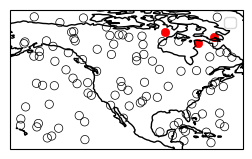

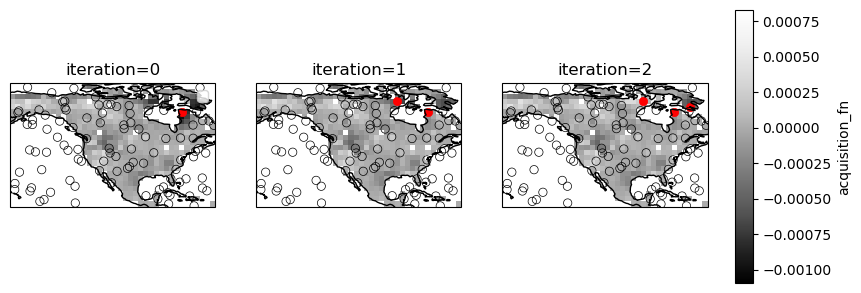

In [15]:
from deepsensor.active_learning.acquisition_fns import OracleMAE

acquisition_fn = OracleMAE(model)
X_new_df, acquisition_fn_ds = greedy_alg_with_groundtruth(acquisition_fn, task, diff=True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

### OracleRMSE

100%|████████████████████████████████████████████████████████████████| 1311/1311 [01:13<00:00, 17.82it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Averaging acquisition function over dims for plotting: ['time']


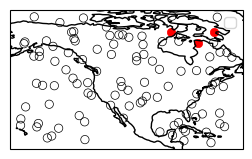

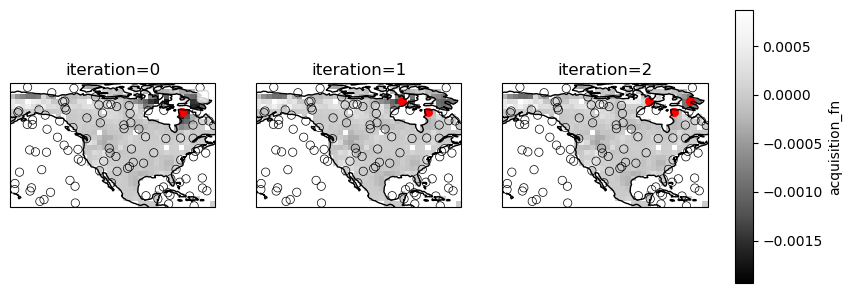

In [16]:
from deepsensor.active_learning.acquisition_fns import OracleRMSE

acquisition_fn = OracleRMSE(model)
X_new_df, acquisition_fn_ds = greedy_alg_with_groundtruth(acquisition_fn, task, diff=True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

### OracleMarginalNLL

100%|████████████████████████████████████████████████████████████████| 1311/1311 [02:26<00:00,  8.96it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Averaging acquisition function over dims for plotting: ['time']


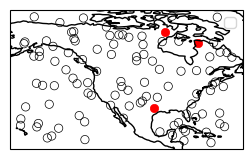

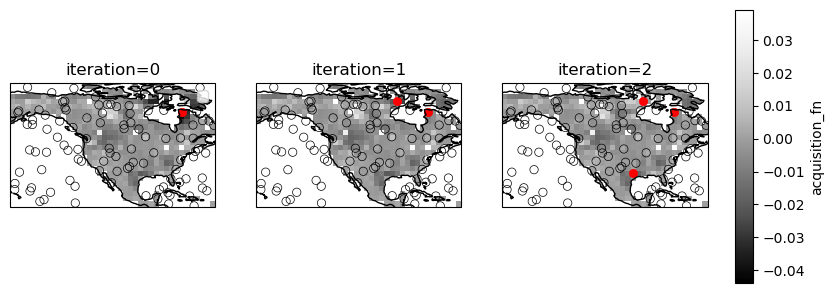

In [17]:
from deepsensor.active_learning.acquisition_fns import OracleMarginalNLL

acquisition_fn = OracleMarginalNLL(model)
X_new_df, acquisition_fn_ds = greedy_alg_with_groundtruth(acquisition_fn, task, diff=True)

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(task, acquisition_fn_ds, X_new_df, data_processor, crs)

## Parallel greedy algorithm

Acquisition functions that inherit from `AcquisitionFunctionParallel` can be computed over all search points in parallel by running the model forwards once.
Parallel acquisition functions are much faster to compute than sequential acquisition functions, which required one forward pass per search point.
This enables finer search grids, averaging acquisition functions over more tasks, and more proposed context points.

In [40]:
greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds,
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    N_new_context=10,
    progress_bar=True,
)

In [41]:
dates = val_dates
tasks = task_loader(dates, (X_c, "all", "all"), seed_override=42)

### Stddev

Use the model's standard deviation at search points as the acquisition function. Maximising this acquisition function will place context points at locations where the model is most uncertain.

100%|██████████████████████████████████████████████████████████████████| 370/370 [00:21<00:00, 17.29it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Averaging acquisition function over dims for plotting: ['time']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


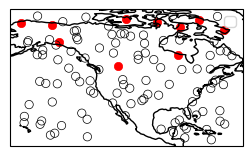

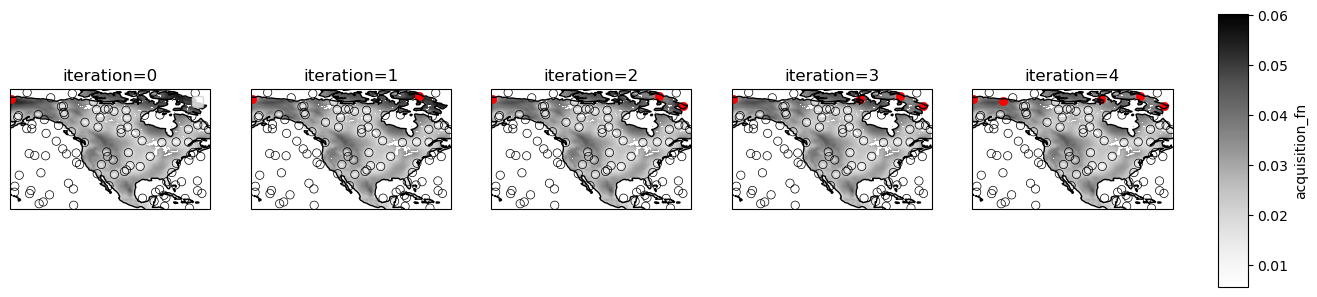

In [42]:
from deepsensor.active_learning.acquisition_fns import Stddev
acquisition_fn = Stddev(model)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, tasks)

fig = deepsensor.plot.placements(tasks[0], X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(tasks[0], acquisition_fn_ds.sel(iteration=slice(0, 4)), X_new_df, data_processor, crs, cmap="Greys")

### ExpectedImprovement

The `ExpectedImprovement` acquisition function can be used to hunt for the most positive or negative values in the data.

We will average the acquisition function over tasks sampled from 52 equally spaced dates in 2020 to make the acquisition function more robust to the weather on a single day.

In [43]:
greedy_alg_with_groundtruth = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds,
    X_s_mask=mask_ds,  # Mask out ocean from search points
    X_t_mask=mask_ds,  # Mask out ocean from target points
    proposed_infill=era5_ds,  # EI requires ground truth after proposal
    N_new_context=10,
    progress_bar=True,
    verbose=True,
)

In [44]:
from deepsensor.active_learning.acquisition_fns import ExpectedImprovement

acquisition_fn = ExpectedImprovement(model)
X_new_df, acquisition_fn_ds = greedy_alg_with_groundtruth(acquisition_fn, tasks)

100%|██████████████████████████████████████████████████████████████████| 370/370 [00:42<00:00,  8.69it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Averaging acquisition function over dims for plotting: ['time']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


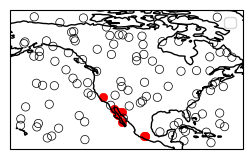

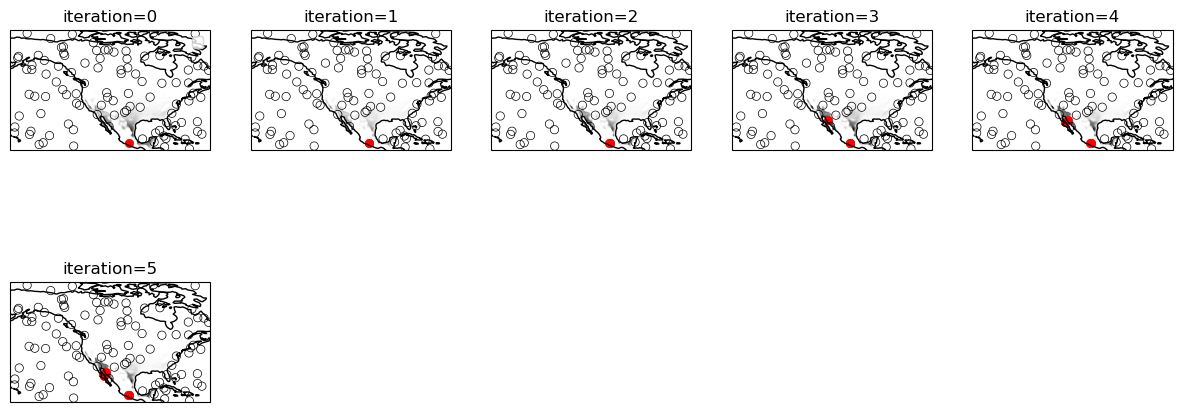

In [45]:
fig = deepsensor.plot.placements(tasks[0], X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(tasks[0], acquisition_fn_ds.sel(iteration=slice(0, 5)), X_new_df, data_processor, crs, cmap="Greys", add_colorbar=False, max_ncol=5)

## Heuristic baseline acquisition functions

Acquisition functions that don't use a model can be used as baselines in sensor placement studies.

### ContextDist

Distance to the closest context point. Maximising this acquisition function will place context points at locations that are furthest from existing context points.

100%|████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.19it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Averaging acquisition function over dims for plotting: ['time']


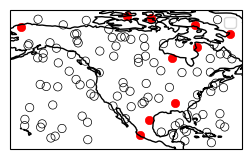

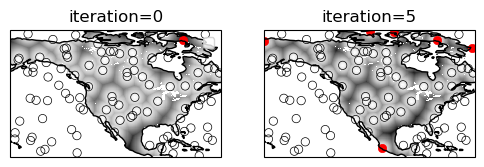

In [34]:
from deepsensor.active_learning.acquisition_fns import ContextDist

acquisition_fn = ContextDist(context_set_idx=0)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, tasks[0])

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)
fig = deepsensor.plot.acquisition_fn(tasks[0], acquisition_fn_ds.sel(iteration=slice(0, 55, 5)), X_new_df, data_processor, crs, cmap="Greys", add_colorbar=False, max_ncol=5)

### Random

Random acquisition function leading to random placements - a useful baseline!

100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 251.40it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


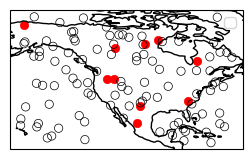

In [35]:
from deepsensor.active_learning.acquisition_fns import Random

acquisition_fn = Random()
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, tasks[0])

fig = deepsensor.plot.placements(task, X_new_df, data_processor, crs)